1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

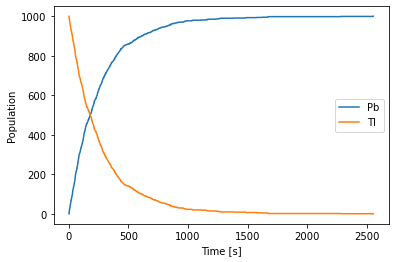

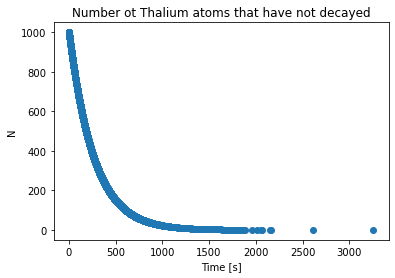

In [7]:
#Answer 
Tl = 1000
Pb = 0

def prob(t):
    tau = 3.052 * 60
    return 1-2**(-1/tau)

Tl_t = [Tl]
Pb_t = [Pb]
time = 1.

while Tl_t[-1] > 0:
    pr = prob(time)
    for i in range(Tl_t[-1]):
        rn = np.random.uniform(0,1)
        if rn < pr :
            Tl -= 1
            Pb += 1
    Tl_t.append(Tl)
    Pb_t.append(Pb)
    time += 1.

time = np.arange(0,time)

plt.figure(figsize=(6, 4))
plt.plot(time,Pb_t, label= 'Pb') 
plt.plot(time,Tl_t, label= 'Tl')
plt.xlabel('Time [s]')
plt.ylabel('Population')
plt.legend()
plt.show()

#With the inverse transform method.
N = 10000
def pdf(x):
    tau = 3.052 * 60
    return 2**(-x/tau)*np.log(2.)/tau

def icdf(p):
    tau = 3.052 * 60
    return - tau * np.log2(1-p)

x = np.random.random(10000)
y = icdf(x)

plt.scatter(y,1000-x*10000)
plt.xlabel('Time [s]')
plt.ylabel('N')
plt.title('Number ot Thalium atoms that have not decayed')
plt.show()


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [3]:
#Answer
def R_scattering(b, Z=79, E=7.7e6):
    e  = 1.60217662e-19 #[C]
    e0 = 8.854e-12      #[F/m]
    return 2 * np.arctan((Z * e) / (2 * np.pi * e0 * E * b))


a0    = 5.29e-11 #[m]
sigma = a0/100
cov   = [[sigma,0],[0,sigma]]
mean  = [0,0]

N = 1000000
x = np.random.normal(0,sigma,N)
y = np.random.normal(0,sigma,N)

theta = R_scattering(np.sqrt(x**2 +y**2))

N_back = len(theta[theta>np.pi/2])
print('The number of particles that "bounce back" is', N_back, 'around',round(N_back/N *100,2),'percent.')

The number of particles that "bounce back" is 1586 around 0.16 percent.


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

<ipython-input-4-bbdf6903765a>:3: RuntimeWarning: divide by zero encountered in reciprocal
  return (np.sin((x*(2-x))**-1))**2
<ipython-input-4-bbdf6903765a>:3: RuntimeWarning: invalid value encountered in sin
  return (np.sin((x*(2-x))**-1))**2


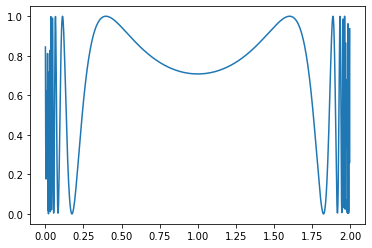

The exact value is 1.4514

The computed value with the hit/miss method is 1.454
The relative error is 0.179 %

The computed value with the mean value method is 1.451547982927488
The relative error is 0.0102 %



In [4]:
#Answer
def f(x):
    return (np.sin((x*(2-x))**-1))**2

x = np.linspace(0.0001, 2, 1000)
plt.plot(x,f(x))
plt.show()

N=100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y < f(x): count+=1
I=2*count/N
print('The exact value is', 1.4514)
print('')
print('The computed value with the hit/miss method is',I)
print('The relative error is',round(abs(1.4514-I)/1.4514 *100,3),'%')
print('')

a = 2/N
I = 0

x = np.linspace(0.0001, 1.9999, N)

for i in x:
    I += a*f(i)
    
print('The computed value with the mean value method is',I)
print('The relative error is',round(abs(1.4514-I)/1.4514 *100,4),'%')
print('')

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [5]:
#Answer
def f(x,y):
    return (x**2+y**2)


# Monte Carlo integration
N=100000
count=0
for i in range(N):
    x=1.- 2*np.random.random()
    y=1.- 2*np.random.random()
    if f(x,y) <= 1.: count+=1
I=4*count/N
print('The area of a circle of unit radius is',I)


def f(x):
    return np.sum(x**2)

N=100000
dimension = 10
radio =1.
count=0
for i in range(N):
    x=1.- 2*np.random.rand(dimension)
    if f(x) <= radio: count+=1
area = 2**dimension
I=area*count/N
print('The volume of a 10 dimensional sphere of unit radius is',I)



The area of a circle of unit radius is 3.14408
The volume of a 10 dimensional sphere of unit radius is 2.72384


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

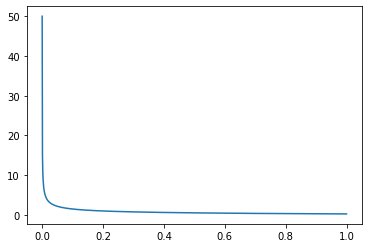

The integral value is 0.8417046561870314


In [6]:
#Answer
def f(x):
    return 1/(np.sqrt(x)*(np.exp(x)+1))

x = np.linspace(0.0001, 1, 1000)
plt.plot(x,f(x))
plt.show()

def w(x):
    return 1/np.sqrt(x)

N = 10000
#x has to be generated acording to the w distribution (I use the inverse method)
def icdf(p):
    return p**2/4
u = np.random.random(N)
x = icdf(u)
x = x/x.max()

Iw = integrate.quad(w, 0, 1)[0]
I  = 1/N * np.sum(1/(np.exp(x)+1))*Iw
print('The integral value is',I)